<a href="https://colab.research.google.com/github/Murcha1990/Raiffaizen_ML_summer2023/blob/main/%D0%97%D0%B0%D0%BD%D1%8F%D1%82%D0%B8%D0%B5_13_recsys/raiff_recsys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Рекомендательные системы

В этом задании будем практиковаться в реализации рекомендательных систем.

Воспользуемся небольшим датасетом с Kaggle: [Articles Sharing and Reading from CI&T Deskdrop](https://www.kaggle.com/gspmoreira/articles-sharing-reading-from-cit-deskdrop).

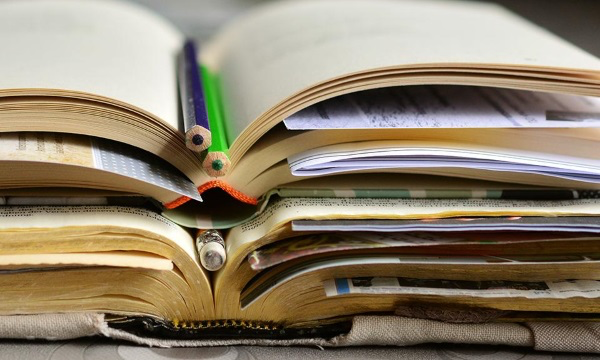

In [1]:
%pylab inline

import numpy as np
import pandas as pd

from tqdm import tqdm_notebook

Populating the interactive namespace from numpy and matplotlib


## Часть 0. Загрузка данных

Загрузим Deskdrop dataset, включающийся в себе логи за 1 год платформы, где пользователи читают статьи.

Данные включают в себя 2 файла:  
- **shared_articles.csv**
- **users_interactions.csv**

Как можно догадаться, в одном описания самих статей (нам понадобятся в контентных моделях), а в другом логи пользователей.

#### shared_articles.csv

Так как в файле перечислены даже удалённые статьи, то мы их сразу удалим (на самом деле они могли бы быть нам полезны для подсчёта различных величин, хоть мы и не можем их рекомендовать).

In [2]:
articles_df = pd.read_csv('https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/shared_articles.csv')
articles_df = articles_df[articles_df['eventType'] == 'CONTENT SHARED']
articles_df.head(2)

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en


#### users_interactions.csv

В колонке eventType описаны действия, которые могли совершать пользователи над статьёй:  
- VIEW
- LIKE
- COMMENT CREATED
- FOLLOW
- BOOKMARK

In [3]:
interactions_df = pd.read_csv('https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/users_interactions.csv')
interactions_df.head()

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN


In [4]:
interactions_df.personId = interactions_df.personId.astype(str)
interactions_df.contentId = interactions_df.contentId.astype(str)
articles_df.contentId = articles_df.contentId.astype(str)

### Предобработка данных

В логах встречаются различные действия пользователей. Однако мы хотим работать лишь с одной величиной, характеризующей всё взаимодействие пользователя со статьёй. Предлагается задать действиям следующие веса:

In [5]:
event_type_strength = {
   'VIEW': 1.0,
   'LIKE': 2.0,
   'BOOKMARK': 2.5,
   'FOLLOW': 3.0,
   'COMMENT CREATED': 4.0,
}

Посчитаем числовую величину "оценки" пользователем статьи с указанными выше весами.

In [6]:
interactions_df['eventStrength'] = interactions_df.eventType.apply(lambda x: event_type_strength[x])
interactions_df['eventStrength']

0        1.0
1        1.0
2        1.0
3        3.0
4        1.0
        ... 
72307    2.0
72308    1.0
72309    1.0
72310    1.0
72311    1.0
Name: eventStrength, Length: 72312, dtype: float64

Ремендательные системы подвержены проблеме холодного старта. Будем работать только с теми пользователями, которые взаимодействовали хотя бы с 5-ю материалами.

Оставим только таких пользователей.

In [7]:
users_interactions_count_df = (
    interactions_df
    .groupby(['personId', 'contentId'])
    .first()
    .reset_index()
    .groupby('personId').size())
print('# users:', len(users_interactions_count_df))

users_with_enough_interactions_df = \
    users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['personId']]
print('# users with at least 5 interactions:',len(users_with_enough_interactions_df))

# users: 1895
# users with at least 5 interactions: 1140


<Axes: >

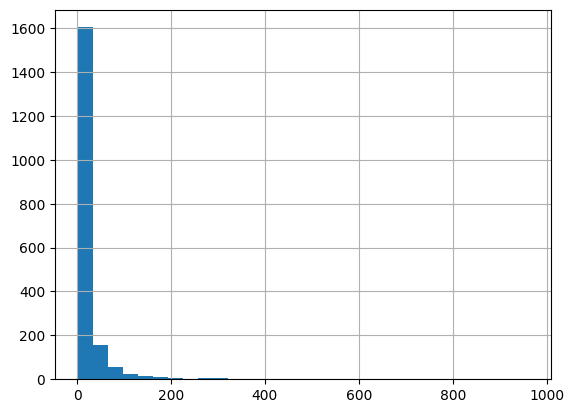

In [8]:
users_interactions_count_df.hist(bins=30)

Оставим только те взаимодействия, которые касаются только отфильтрованных пользователей.

In [9]:
interactions_from_selected_users_df = interactions_df.loc[np.in1d(interactions_df.personId,
            users_with_enough_interactions_df)]

In [10]:
print('# interactions before:', interactions_df.shape)
print('# interactions after:', interactions_from_selected_users_df.shape)

# interactions before: (72312, 9)
# interactions after: (69868, 9)


В данной постановке каждый пользователей мог взаимодействовать с каждой статьёй более 1 раза (как минимум совершая различные действия). Предлагается "схлопнуть" все действия в одно взаимодействие с весом, равным сумме весов.

Однако полученное число будет в том числе тем больше, чем больше действий произвёл человек. Чтобы уменьшить разброс предлагается взять логарифм от полученного числа (можно придумывать другие веса действиям и по-другому обрабатывать значения).

Также сохраним последнее значение времени взаимодействия для разделениея выборки на обучение и контроль.

In [11]:
def smooth_user_preference(x):
    return math.log(1+x, 2)

interactions_full_df = (
    interactions_from_selected_users_df
    .groupby(['personId', 'contentId']).eventStrength.sum()
    .apply(smooth_user_preference)
    .reset_index().set_index(['personId', 'contentId'])
)
interactions_full_df['last_timestamp'] = (
    interactions_from_selected_users_df
    .groupby(['personId', 'contentId'])['timestamp'].last()
)

interactions_full_df = interactions_full_df.reset_index()
interactions_full_df.head(20)

,personId,contentId,eventStrength,last_timestamp
0,-1007001694607905623,-5065077552540450930,1.000000,1470395911
1,-1007001694607905623,-6623581327558800021,1.000000,1487240080
2,-1007001694607905623,-793729620925729327,1.000000,1472834892
3,-1007001694607905623,1469580151036142903,1.000000,1487240062
4,-1007001694607905623,7270966256391553686,1.584963,1485994324
5,-1007001694607905623,8729086959762650511,1.000000,1487240086
6,-1032019229384696495,-1006791494035379303,1.000000,1469129122
7,-1032019229384696495,-1039912738963181810,1.000000,1459376415
8,-1032019229384696495,-1081723567492738167,2.000000,1464054093
9,-1032019229384696495,-1111518890369033396,1.000000,1470109122


Разобьём выборку на обучение и контроль по времени.

In [12]:
from sklearn.model_selection import train_test_split

split_ts = 1475519530
interactions_train_df = interactions_full_df.loc[interactions_full_df.last_timestamp < split_ts].copy()
interactions_test_df = interactions_full_df.loc[interactions_full_df.last_timestamp >= split_ts].copy()

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

interactions_train_df

# interactions on Train set: 29329
# interactions on Test set: 9777


,personId,contentId,eventStrength,last_timestamp
0,-1007001694607905623,-5065077552540450930,1.0,1470395911
2,-1007001694607905623,-793729620925729327,1.0,1472834892
6,-1032019229384696495,-1006791494035379303,1.0,1469129122
7,-1032019229384696495,-1039912738963181810,1.0,1459376415
8,-1032019229384696495,-1081723567492738167,2.0,1464054093
...,...,...,...,...
39099,997469202936578234,9112765177685685246,2.0,1472479493
39100,998688566268269815,-1255189867397298842,1.0,1474567164
39101,998688566268269815,-401664538366009049,1.0,1474567449
39103,998688566268269815,6881796783400625893,1.0,1474567675


Также разбить данные можно не опираясь на временной фактор:
```python
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['personId'],
                                   test_size=0.25,
                                   random_state=42)

```
Как повлият такое разбиение на итоговый результат?

Для удобства подсчёта качества запишем данные в формате, где строка соответствует пользователю, а столбцы будут истинными метками и предсказаниями в виде списков.

In [13]:
interactions = (
    interactions_train_df
    .groupby('personId')['contentId'].agg(lambda x: list(x))
    .reset_index()
    .rename(columns={'contentId': 'true_train'})
    .set_index('personId')
)

interactions['true_test'] = (
    interactions_test_df
    .groupby('personId')['contentId'].agg(lambda x: list(x))
)

# заполнение пропусков пустыми списками
interactions.loc[pd.isnull(interactions.true_test), 'true_test'] = [
    [''] for x in range(len(interactions.loc[pd.isnull(interactions.true_test), 'true_test']))]

interactions.head(5)

,true_train,true_test
personId,,
-1007001694607905623,"[-5065077552540450930, -793729620925729327]","[-6623581327558800021, 1469580151036142903, 72..."
-1032019229384696495,"[-1006791494035379303, -1039912738963181810, -...","[-1415040208471067980, -2555801390963402198, -..."
-108842214936804958,"[-1196068832249300490, -133139342397538859, -1...","[-2780168264183400543, -3060116862184714437, -..."
-1130272294246983140,"[-1150591229250318592, -1196068832249300490, -...","[-1606980109000976010, -1663441888197894674, -..."
-1160159014793528221,"[-133139342397538859, -387651900461462767, 377...",[-3462051751080362224]


## Часть 1: Baseline (модель по популярности)

Самой простой моделью рекомендаций (при этом достаточно сильной!) является модель, которая рекомендует наиболее популярные предметы.

Реализуем её. Давайте считать, что рекомендуем мы по 10 материалов (такое ограничение на размер блока на сайте).

Посчитаем популярность каждой статьи, как сумму всех "оценок" взаимодействий с ней. Отсортируем материалы по их популярности.

In [14]:
popular_content = (
    interactions_train_df
    .groupby('contentId')
    .eventStrength.sum().reset_index()
    .sort_values('eventStrength', ascending=False)
    .contentId.values
)

In [15]:
print(articles_df.loc[articles_df.contentId == popular_content[1]]['title'].values)

['Novo workaholic trabalha, pratica esportes e tem tempo para a família. Conheça']


In [16]:
print(articles_df.loc[articles_df.contentId == popular_content[2363]]['title'].values)

['Sunset Blvd. (1950)']


Теперь необходимо сделать предсказания для каждого пользователя. Не забываем, что надо рекомендовать то, что пользователь ещё не читал (для этого нужно проверить, что материал не встречался в true_train).

In [17]:
top_k = 10

interactions['prediction_popular'] = (
    interactions.true_train
    .apply(
        lambda x:
        popular_content[~np.in1d(popular_content, x)][:top_k]
    )
)

interactions['prediction_popular'][0]

array(['-6783772548752091658', '-133139342397538859',
       '-8208801367848627943', '8224860111193157980',
       '7507067965574797372', '-2358756719610361882',
       '-6843047699859121724', '-1297580205670251233',
       '8657408509986329668', '3367026768872537336'], dtype=object)

In [18]:
interactions['prediction_popular'][1]

array(['-6783772548752091658', '-133139342397538859',
       '-8208801367848627943', '7507067965574797372',
       '-2358756719610361882', '-1297580205670251233',
       '8657408509986329668', '3367026768872537336',
       '2581138407738454418', '-1633984990770981161'], dtype=object)

Настало время оценить качество. Посчитаем precision@10 для каждого пользователя (доля угаданных рекомендаций). Усредним по всем пользователям. Везде далее будем считать эту же метрику.

In [19]:
def calc_precision(column):

    return (
        interactions
        .apply(
            lambda row:
            len(set(row['true_test']).intersection(
                set(row[column]))) /
            min(len(row['true_test']) + 0.001, 10.0),
            axis=1)).mean()

In [20]:
calc_precision('prediction_popular')

0.006454207722621089

## Часть 2. Коллаборативная фильтрация.

Перейдём к более сложному механизму рекомендаций, а именно коллаборативной фильтрации. Суть коллаборативной фильтрации в том, что учитывается схожесть пользователей и товаров между собой, а не факторы, которые их описывают.

Для начала для удобства составим матрицу "оценок" пользователей. Нули будут обозначать отсутствие взаимодействия.

In [21]:
ratings = pd.pivot_table(
    interactions_train_df,
    values='eventStrength',
    index='personId',
    columns='contentId').fillna(0)

### Memory-based

Посчитаем схожести пользователей с помощью корреляции Пирсона. Для каждой пары учитываем только ненулевые значения.

Для скорости работы лучше переходить от pandas к numpy.

In [22]:
ratings_m = ratings.values

In [23]:
similarity_users = np.zeros((len(ratings_m), len(ratings_m)))

for i in tqdm_notebook(range(len(ratings_m)-1)):
    for j in range(i+1, len(ratings_m)):

        # nonzero elements of two users
        mask_uv = (ratings_m[i] != 0) & (ratings_m[j] != 0)

        # continue if no intersection
        if np.sum(mask_uv) == 0:
            continue

        # get nonzero elements
        ratings_v = ratings_m[i, mask_uv]
        ratings_u = ratings_m[j, mask_uv]

        # for nonzero std
        if len(np.unique(ratings_v)) < 2 or len(np.unique(ratings_u)) < 2:
            continue
        similarity_users[i,j] = np.corrcoef(ratings_v, ratings_u)[0, 1]
        similarity_users[j,i] = similarity_users[i,j]

<ipython-input-23-29d9ad5829ae>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(ratings_m)-1)):


  0%|          | 0/1111 [00:00<?, ?it/s]

Теперь у нас есть матрицы схожести пользователей. Их можно использовать для рекомендаций.

Для каждого пользователя:

1. Найдём пользователей с похожестью больше $\alpha$ на нашего пользователя.
2. Посчитаем для каждой статьи долю пользователей (среди выделенных на первом шаге), которые взаимодействовали со статьёй.
3. Порекомендуем статьи с наибольшими долями со второго шага (среди тех, которые пользователь ещё не видел).

В нашем примере данных не очень много, поэтому возьмём $\alpha = 0$.

После того, как будут сделаны предсказания (новый столбец в interactions), посчитаем качество по той же метрике.

In [24]:
prediction_user_based = []

for i in tqdm_notebook(range(len(similarity_users))):
    users_sim = similarity_users[i] > 0
    if len(users_sim) == 0:
        prediction_user_based.append([])
    else:
        tmp_recommend = np.argsort(ratings_m[users_sim].sum(axis=0))[::-1]
        tmp_recommend = ratings.columns[tmp_recommend]
        recommend = np.array(tmp_recommend)[~np.in1d(tmp_recommend, interactions.iloc[i])][:10]
        prediction_user_based.append(list(recommend))

interactions['prediction_user_based'] = prediction_user_based

<ipython-input-24-069b233dd2c7>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(similarity_users))):


  0%|          | 0/1112 [00:00<?, ?it/s]

In [25]:
calc_precision('prediction_user_based')

0.003541692918885616

### Модель со скрытыми переменными

Реализуем подход с разложением матрицы оценок. Для этого сделаем сингулярное разложение (svd в scipy.linalg), на выходе вы получите три матрицы.

Заметим, что мы используем матрицу с нулями, будто отсутствующие взаимодействия негативные, что странно.

Если бы мы учили модель со скрытыми переменными с помощью стохастического градиентного спуска, то неизвестные взаимодействия могли бы не использовать.

In [26]:
from scipy.linalg import svd

In [27]:
U, sigma, V = svd(ratings)
print(ratings.shape, U.shape, sigma.shape, V.shape)

(1112, 2366) (1112, 1112) (1112,) (2366, 2366)


In [28]:
Sigma = np.zeros((1112, 2366))
Sigma[:1112, :1112] = np.diag(sigma)

new_ratings = U.dot(Sigma).dot(V)

print(sum(sum((new_ratings - ratings.values) ** 2)))

9.51524958314497e-25


Значения у матрицы с сингулярными числами отсортированы по убыванию. Допустим мы хотим оставить только первые 100 компонент (и получить скрытые представления размерности 100). Для этого необходимо оставить 100 столбцов в матрице U, оставить из sigma только первые 100 значений (и сделать из них диагональную матрицу) и 100 столбцов в матрице V. Перемножим преобразованные матрицы ($\hat{U}, \hat{sigma}, \hat{V^T}$), чтобы получить восстановленную матрицу оценок.

In [29]:
K = 100

sigma[K:] = 0
Sigma = np.zeros((1112, 2366))
Sigma[:1112, :1112] = np.diag(sigma)

Посчитаем качество аппроксимации матрицы по норме Фробениуса (среднеквадратичную ошибку между всеми элементами соответствующими элементами двух матриц). Сравним его с простым бейзлайном с константным значением, равным среднему значению исходной матрицы. У аппроксимации ошибка должна получиться ниже.

In [30]:
new_ratings = U.dot(Sigma).dot(V)

print(sum(sum((new_ratings - ratings.values) ** 2)))
print(sum(sum((ratings.values.mean() - ratings.values) ** 2)))

25843.424898912774
78622.13000466056


Теперь можно делать предсказания по матрице. Сделаем их (не забываем про то, что уже было просмотрено пользователем), оценим качество. Для этого необходимо для каждого пользователя найти предметы с наибольшими оценками в восстановленной матрице.

In [31]:
new_ratings = pd.DataFrame(new_ratings, index=ratings.index, columns=ratings.columns)

predictions = []

for personId in tqdm_notebook(interactions.index):
    prediction = (
        new_ratings
        .loc[personId]
        .sort_values(ascending=False)
        .index.values
    )

    predictions.append(
        list(prediction[~np.in1d(
            prediction,
            interactions.loc[personId, 'true_train'])])[:top_k])

interactions['prediction_svd'] = predictions

<ipython-input-31-ff40a25cb4f2>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for personId in tqdm_notebook(interactions.index):


  0%|          | 0/1112 [00:00<?, ?it/s]

In [32]:
calc_precision('prediction_svd')

0.012212989310270756

## Часть 3. Контентные  модели

В этой части реализуем альтернативный подход к рекомендательным системам — контентные модели.

Теперь мы будем оперировать не матрицей с оценками, а классической для машинного обучения матрицей объекты-признаки. Каждый объект будет характеризовать пару user-item и содержать признаки, описывающие как пользователя, так и товар. Кроме этого признаки могут описывать и саму пару целиком.

Матрица со всеми взаимодействиями уже получена нами на этапа разбиения выборки на 2 части.

Будем обучать классификатор на взаимодействие, а для него нужны отрицательные примеры. Добавим случайные отсутствующие взаимодействия как отрицательные.

Заметим, что модель оценивает каждую пару потенциального взаимодействия, а значит, надо подготовить выборку из всех возможных пар из пользователей и статей.

In [33]:
test_personId = np.repeat(interactions.index, len(ratings.columns))
test_contentId = list(ratings.columns) * len(interactions)
test = pd.DataFrame(
    np.array([test_personId, test_contentId]).T,
    columns=['personId', 'contentId'])

interactions_train_df = pd.concat((
    interactions_train_df,
    test.loc[
        np.random.permutation(test.index)[
            :4*len(interactions_train_df)]]), ignore_index=True)
interactions_train_df.eventStrength.fillna(0, inplace=True)

Придумаем и добавим признаков о пользователях и статьях. Сначала добавим информацию о статьях в данные о взаимодействиях.

In [34]:
interactions_train_df = interactions_train_df.merge(articles_df, how='left', on='contentId')
interactions_test_df = interactions_test_df.merge(articles_df, how='left', on='contentId')

In [35]:
features_start = len(interactions_train_df.columns)

После обучения модели нам придётся делать предсказания на тестовой выборке для всех возможных пар статья-пользователь. Подготовим такую матрицу, чтобы параллельно посчитать признаки для неё.

In [36]:
test_personId = np.repeat(interactions.index, len(articles_df))
test_contentId = list(articles_df.contentId) * len(interactions)
test = pd.DataFrame(
    np.array([test_personId, test_contentId]).T,
    columns=['personId', 'contentId'])
test = test.merge(articles_df, how='left', on='contentId')

test.head()

,personId,contentId,timestamp,eventType,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
0,-1007001694607905623,-4110354420726924665,1459193988,CONTENT SHARED,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,-1007001694607905623,-7292285110016212249,1459194146,CONTENT SHARED,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
2,-1007001694607905623,-6151852268067518688,1459194474,CONTENT SHARED,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
3,-1007001694607905623,2448026894306402386,1459194497,CONTENT SHARED,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
4,-1007001694607905623,-2826566343807132236,1459194522,CONTENT SHARED,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en


Добавим признаки-индикаторы возможных значений contentType.

In [37]:
interactions_train_df['is_HTML'] = interactions_train_df.contentType == 'HTML'
interactions_train_df['is_RICH'] = interactions_train_df.contentType == 'RICH'
interactions_train_df['is_VIDEO'] = interactions_train_df.contentType == 'VIDEO'

test['is_HTML'] = test.contentType == 'HTML'
test['is_RICH'] = test.contentType == 'RICH'
test['is_VIDEO'] = test.contentType == 'VIDEO'

Добавим признаки "длина названия" и "длина текста" + некоторые проверки на ключевые слова.

In [38]:
interactions_train_df['title_length'] = interactions_train_df.title.fillna('').apply(len)
interactions_train_df['text_length'] = interactions_train_df.text.fillna('').apply(len)

test['title_length'] = test.title.fillna('').apply(len)
test['text_length'] = test.text.fillna('').apply(len)

interactions_train_df['has_new'] = \
    interactions_train_df.title.fillna('').apply(lambda x: 'new' in x.lower())
interactions_train_df['has_why'] = \
    interactions_train_df.title.fillna('').apply(lambda x: 'why' in x.lower())
interactions_train_df['has_how'] = \
    interactions_train_df.title.fillna('').apply(lambda x: 'how' in x.lower())
interactions_train_df['has_ai'] = \
    interactions_train_df.title.fillna('').apply(lambda x: 'ai' in x.lower())

test['has_new'] = \
    test.title.fillna('').apply(lambda x: 'new' in x.lower())
test['has_why'] = \
    test.title.fillna('').apply(lambda x: 'why' in x.lower())
test['has_how'] = \
    test.title.fillna('').apply(lambda x: 'how' in x.lower())
test['has_ai'] = \
    test.title.fillna('').apply(lambda x: 'ai' in x.lower())

Добавим признаки-индикаторы языка.

In [39]:
interactions_train_df['is_lang_en'] = interactions_train_df.lang == 'en'
interactions_train_df['is_lang_pt'] = interactions_train_df.lang == 'pt'

test['is_lang_en'] = test.lang == 'en'
test['is_lang_pt'] = test.lang == 'pt'

Обучим на полученных признаках градиентный бустинг.

In [40]:
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.6 MB/s eta 0:00:00


In [41]:
import catboost

model = catboost.CatBoostClassifier()

model.fit(interactions_train_df[interactions_train_df.columns[features_start:]],
          np.array(interactions_train_df.eventStrength > 0, dtype=int))

Learning rate set to 0.086682
0:	learn: 0.6577059	total: 75.8ms	remaining: 1m 15s
1:	learn: 0.6287317	total: 102ms	remaining: 50.8s
2:	learn: 0.6050960	total: 122ms	remaining: 40.5s
3:	learn: 0.5859215	total: 142ms	remaining: 35.4s
4:	learn: 0.5701312	total: 162ms	remaining: 32.2s
5:	learn: 0.5568569	total: 193ms	remaining: 32s
6:	learn: 0.5462885	total: 213ms	remaining: 30.2s
7:	learn: 0.5374402	total: 237ms	remaining: 29.4s
8:	learn: 0.5302663	total: 263ms	remaining: 28.9s
9:	learn: 0.5243805	total: 281ms	remaining: 27.9s
10:	learn: 0.5193646	total: 314ms	remaining: 28.2s
11:	learn: 0.5152675	total: 341ms	remaining: 28.1s
12:	learn: 0.5116302	total: 368ms	remaining: 27.9s
13:	learn: 0.5086418	total: 398ms	remaining: 28s
14:	learn: 0.5061859	total: 422ms	remaining: 27.7s
15:	learn: 0.5040471	total: 446ms	remaining: 27.4s
16:	learn: 0.5024192	total: 472ms	remaining: 27.3s
17:	learn: 0.5008993	total: 499ms	remaining: 27.2s
18:	learn: 0.4998364	total: 519ms	remaining: 26.8s
19:	learn: 0.

Сделаем предсказания на тестовой выборке, сформируем из них рекомендации.

In [42]:
top_k = 10

predictions = model.predict_proba(test[interactions_train_df.columns[features_start:]])[:, 1]
test['predictions'] = predictions

test = test.sort_values('predictions', ascending=False)
predictions = test.groupby('personId')['contentId'].aggregate(list)
tmp_predictions = []

for personId in tqdm_notebook(interactions.index):
    prediction = np.array(predictions.loc[personId])

    tmp_predictions.append(
        list(prediction[~np.in1d(
            prediction,
            interactions.loc[personId, 'true_train'])])[:top_k])

interactions['prediction_content'] = tmp_predictions

<ipython-input-42-104d42c29fab>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for personId in tqdm_notebook(interactions.index):


  0%|          | 0/1112 [00:00<?, ?it/s]

Оценим их качество.

In [43]:
calc_precision('prediction_content')

0.01584447205553872